# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — её сделали ранее.

Необходимо построить модель с максимально большим значением *accuracy*. Нужно довести долю правильных ответов по крайней мере до 0.75.

#### Ход исследования

- исследуем предоставленные данные
- разобьем данные на тренировочную, валидационную и тестовую выборки
- создадим, обучим несколько разных и выберем наилучшую модель
- проверим результат на тестовой выборке, и сравним с работой dummy модели


#### Итоговый вывод:

В данном проекте мы ознакомились с данными о пользователях оператора сотовой связи для создания модели для задачи классификации, которая выбирала бы подходящий тариф на основании данных о пользователях котороые уже им пользуются.

Мы выполнили дополнительную обработку данных проверив на корреляцию отсеяли лишний столбец с количеством звонков

Разбили датасет на три части для обучения валидации и окончательной проверки

Построили три модели с несколькими возможными вариантами гиперпараметров

Условие для проекта accuracy > 0.75 выполнено

На основании результатов исследования для рекомендации тарифов рекомендуется использовать модель со следующими параметрами
RandomForestClassifier(max_depth=6, n_estimators=31, random_state=47)

### Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

*    сalls — количество звонков,
*    minutes — суммарная длительность звонков в минутах,
*    messages — количество sms-сообщений,
*    mb_used — израсходованный интернет-трафик в Мб,
*   is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откроем и изучим данные

Импортируем необходимые библиотеки для работы

In [20]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn import tree
from sklearn import metrics, model_selection # For visual
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from joblib import dump 

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



Сохраним датасет в переменную `data`

In [21]:
pth1 = '/content/drive/MyDrive/data/users_behavior.csv' # Colab
pth2 = 'users_behavior.csv'                   # Тренажер
if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print("Проверьте правильность пути к датасету")

Выведем первые 10 строк на экран

In [22]:
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Данные в столбцах calls, messages подразумевают целые значения, преобразуем их

In [23]:
data[['calls', 'messages']] = data[['calls', 'messages']].astype('int')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int32  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int32  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int32(2), int64(1)
memory usage: 100.6 KB


Посмотрим как распределены данные в выборке

In [25]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Минимальные значения во всех столбцах 0 проверим не совпадют ли они по всем столбцам

In [26]:
data.query('calls == 0')

,calls,minutes,messages,mb_used,is_ultra
54,0,0.0,33,14010.33,1
247,0,0.0,35,16444.99,1
264,0,0.0,21,19559.55,0
351,0,0.0,8,35525.61,1
390,0,0.0,25,19088.67,1
484,0,0.0,191,32448.02,1
551,0,0.0,24,18701.54,1
647,0,0.0,30,10236.20,1
769,0,0.0,32,17206.44,0
884,0,0.0,180,32045.73,1


In [27]:
data.query('calls == 0').index == data.query('minutes == 0').index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

Там где 0 звонков там 0 минут, все правильно

In [28]:
data.query('calls == 0')['calls'].count()

40

40 пользователей за месяц ни разу не позвонили, но интерент и смс использовали

In [29]:
data.query('messages == 0')

,calls,minutes,messages,mb_used,is_ultra
14,108,587.90,0,14406.50,1
15,6,22.13,0,2710.09,0
16,2,18.73,0,588.89,0
30,41,276.81,0,19815.62,0
35,120,814.85,0,20427.00,1
...,...,...,...,...,...
3180,19,165.05,0,9607.85,0
3182,63,422.89,0,9697.05,0
3186,95,646.21,0,9432.93,1
3199,104,702.47,0,23611.32,0


497 пользователей не отправили ни одной смс за месяц

In [30]:
data.query('mb_used == 0')

,calls,minutes,messages,mb_used,is_ultra
572,24,213.76,21,0.0,1
650,41,244.59,39,0.0,1
1298,2,11.96,3,0.0,1
1937,23,171.55,2,0.0,1
1954,4,46.98,1,0.0,0
1963,33,215.67,32,0.0,1
2048,53,243.98,41,0.0,1
2363,40,227.89,38,0.0,1
2892,40,300.10,35,0.0,1
2978,45,270.14,29,0.0,1


In [31]:
data.query('mb_used == 0')['mb_used'].count()

11

Всего 11 клиентов не пользовались интернетом на протяжении месяца

In [32]:
1 - data['is_ultra'].mean()

0.693528313627878

Целевой признак позволяет разделить выборку 70/30, то есть чтобы проверить что наша модель ищет какие-либо зависимости помимо деления по основному признаку, результат модели должен быть лучше 0,694

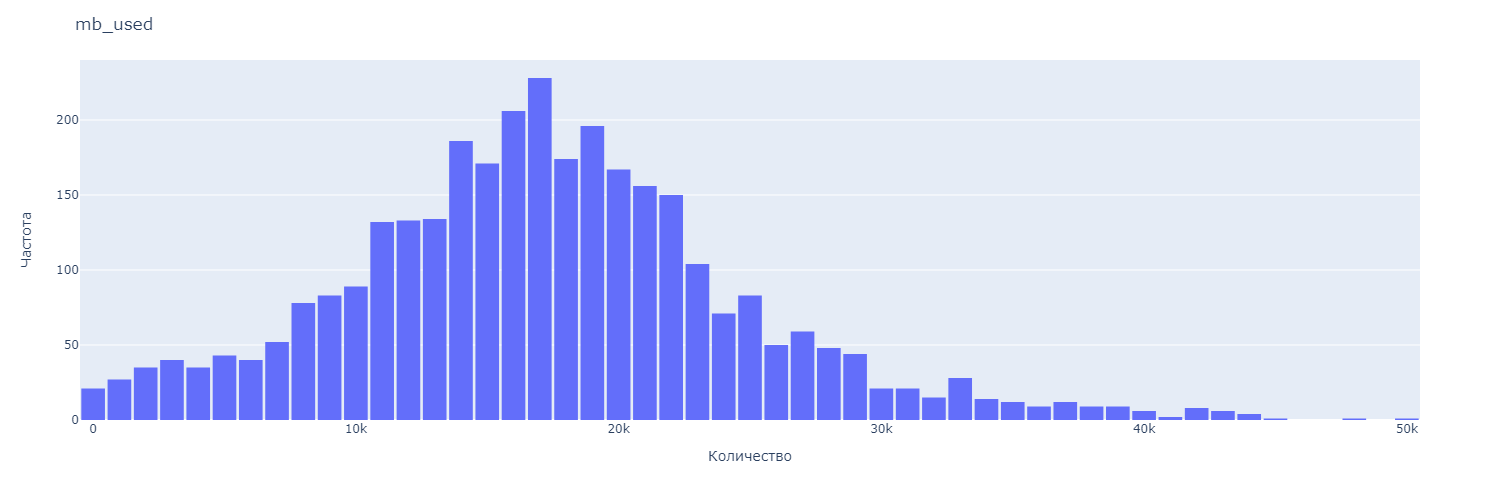

In [33]:
for column in data.columns.drop('is_ultra').unique():
    fig = px.histogram(data, x=column)
    fig.update_layout(bargap=0.1,
                      title_text=column,
                      xaxis_title_text='Количество',
                      yaxis_title_text='Частота',
                      width=1500,
                      height=500
                      )

fig.show('png')

В каждом столбце выделяется значительное количество значений с 0 кроме mb_used, особенно messages

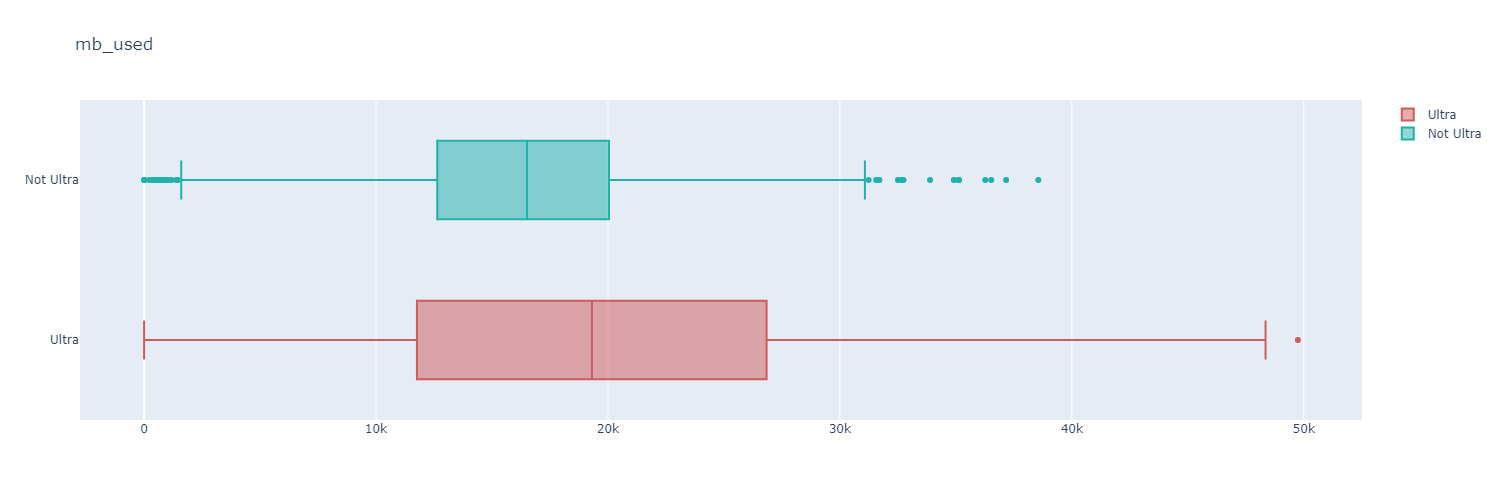

In [34]:
for column in data.columns.drop('is_ultra').unique():
    fig = go.Figure()
    fig.add_trace(go.Box(x=data.query('is_ultra == 1')[column], name='Ultra',
                    marker_color = 'indianred'))
    fig.add_trace(go.Box(x=data.query('is_ultra == 0')[column], name = 'Not Ultra',
                    marker_color = 'lightseagreen'))
    fig.update_layout(title_text=column,
                      width=1500,
                      height=500)
    fig.update_traces(orientation='h')

fig.show('png')

Пользователи тарифа Ultra больше расходуют трафика минут и сообщений чем остальные. Возможно тарифы Ultra включают в себя предоплаченные пакеты

Проверим корреляции между столбцами

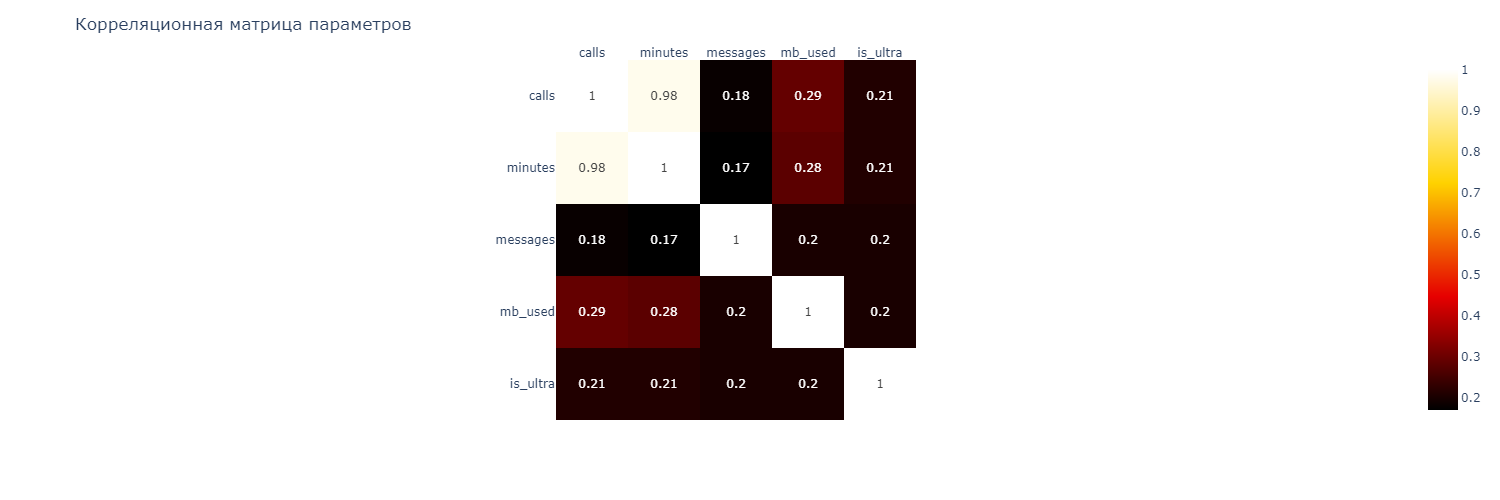

In [35]:
corr_matrix = data.corr().round(2)
    
fig = px.imshow(corr_matrix,
                text_auto=True,
                width=600, 
                height=600,
                color_continuous_scale='Hot')
    
fig.update_xaxes(side="top")
fig.update_layout(title="Корреляционная матрица параметров",
                  width=1500,
                  height=500
                  )

fig.show('png')

Видно сильную корреляцию между количеством звонков и минутами разговоров. Для использования модели столбец с количеством звонков использовать не будем

In [36]:
data = data.drop('calls', axis=1)

Окончательный вид датасета для работы с моделями

In [37]:
data.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83,19915.42,0
1,516.75,56,22696.96,0
2,467.66,86,21060.45,0
3,745.53,81,8437.39,1
4,418.74,1,14502.75,0


**Вывод:**
В представленном датасете 5 столбцов(признаков), о 3214 клиентах, за один месяц.
Исправлены типы данных в столбцах calls, messages
Обнаружено что реже всего пользователи пользуются услугой отправки СМС
Также замечено что те пользователи которые перешли на тариф Ultra в среднем больше использут услуги в большем объеме
Найдена сильная корреляция между количеством звонков и объемом потраченных минут, на основании которой принято решение избавиться от столбца с количеством звонков

## Разбиение данных на выборки

Проведем разбиение данных на 3 выборки

In [38]:
data_train_valid, data_test = train_test_split(data, test_size=0.2, random_state=47)
features_test = data_test.drop(['is_ultra'], axis=1)
target_test = data_test['is_ultra']


data_train, data_valid = train_test_split(data_train_valid, test_size=0.25, random_state=47)
features_train = data_train.drop(['is_ultra'], axis=1)
target_train = data_train['is_ultra']


features_valid = data_valid.drop(['is_ultra'], axis=1)
target_valid = data_valid['is_ultra']

`data_train` - для обучения модели

In [39]:
print('Доля от общего размера:', round(len(data_train)/len(data), 2))
print('Cтрок, столбцов:', data_train.shape)

Доля от общего размера: 0.6
Cтрок, столбцов: (1928, 4)


`data_valid` - для ее валидации

In [40]:
print('Доля от общего размера:', round(len(data_valid)/len(data), 2))
print('Cтрок, столбцов:', data_valid.shape)

Доля от общего размера: 0.2
Cтрок, столбцов: (643, 4)


`data_test` - для окончательной проверки качества

In [41]:
print('Доля от общего размера:', round(len(data_test)/len(data), 2))
print('Cтрок, столбцов:', data_test.shape)

Доля от общего размера: 0.2
Cтрок, столбцов: (643, 4)


## Создадим и исследуем модели

Используем три модели, выберем ту которая покажет лучший параметр Accuracy 

In [42]:
# DecisionTree
clf1 = DecisionTreeClassifier()
param_dist = {
        'max_depth':range(2,6,1),
        'random_state':range(47,48,1)
        }

grid = GridSearchCV(clf1, param_dist, scoring = 'accuracy', n_jobs = -1)
grid.fit(features_train, target_train)
best_decision_tree = grid.best_estimator_

print(best_decision_tree)
print("Accuracy наилучшей модели на валидационной выборке:", round(grid.best_score_, 3))

DecisionTreeClassifier(max_depth=5, random_state=47)
Accuracy наилучшей модели на валидационной выборке: 0.787


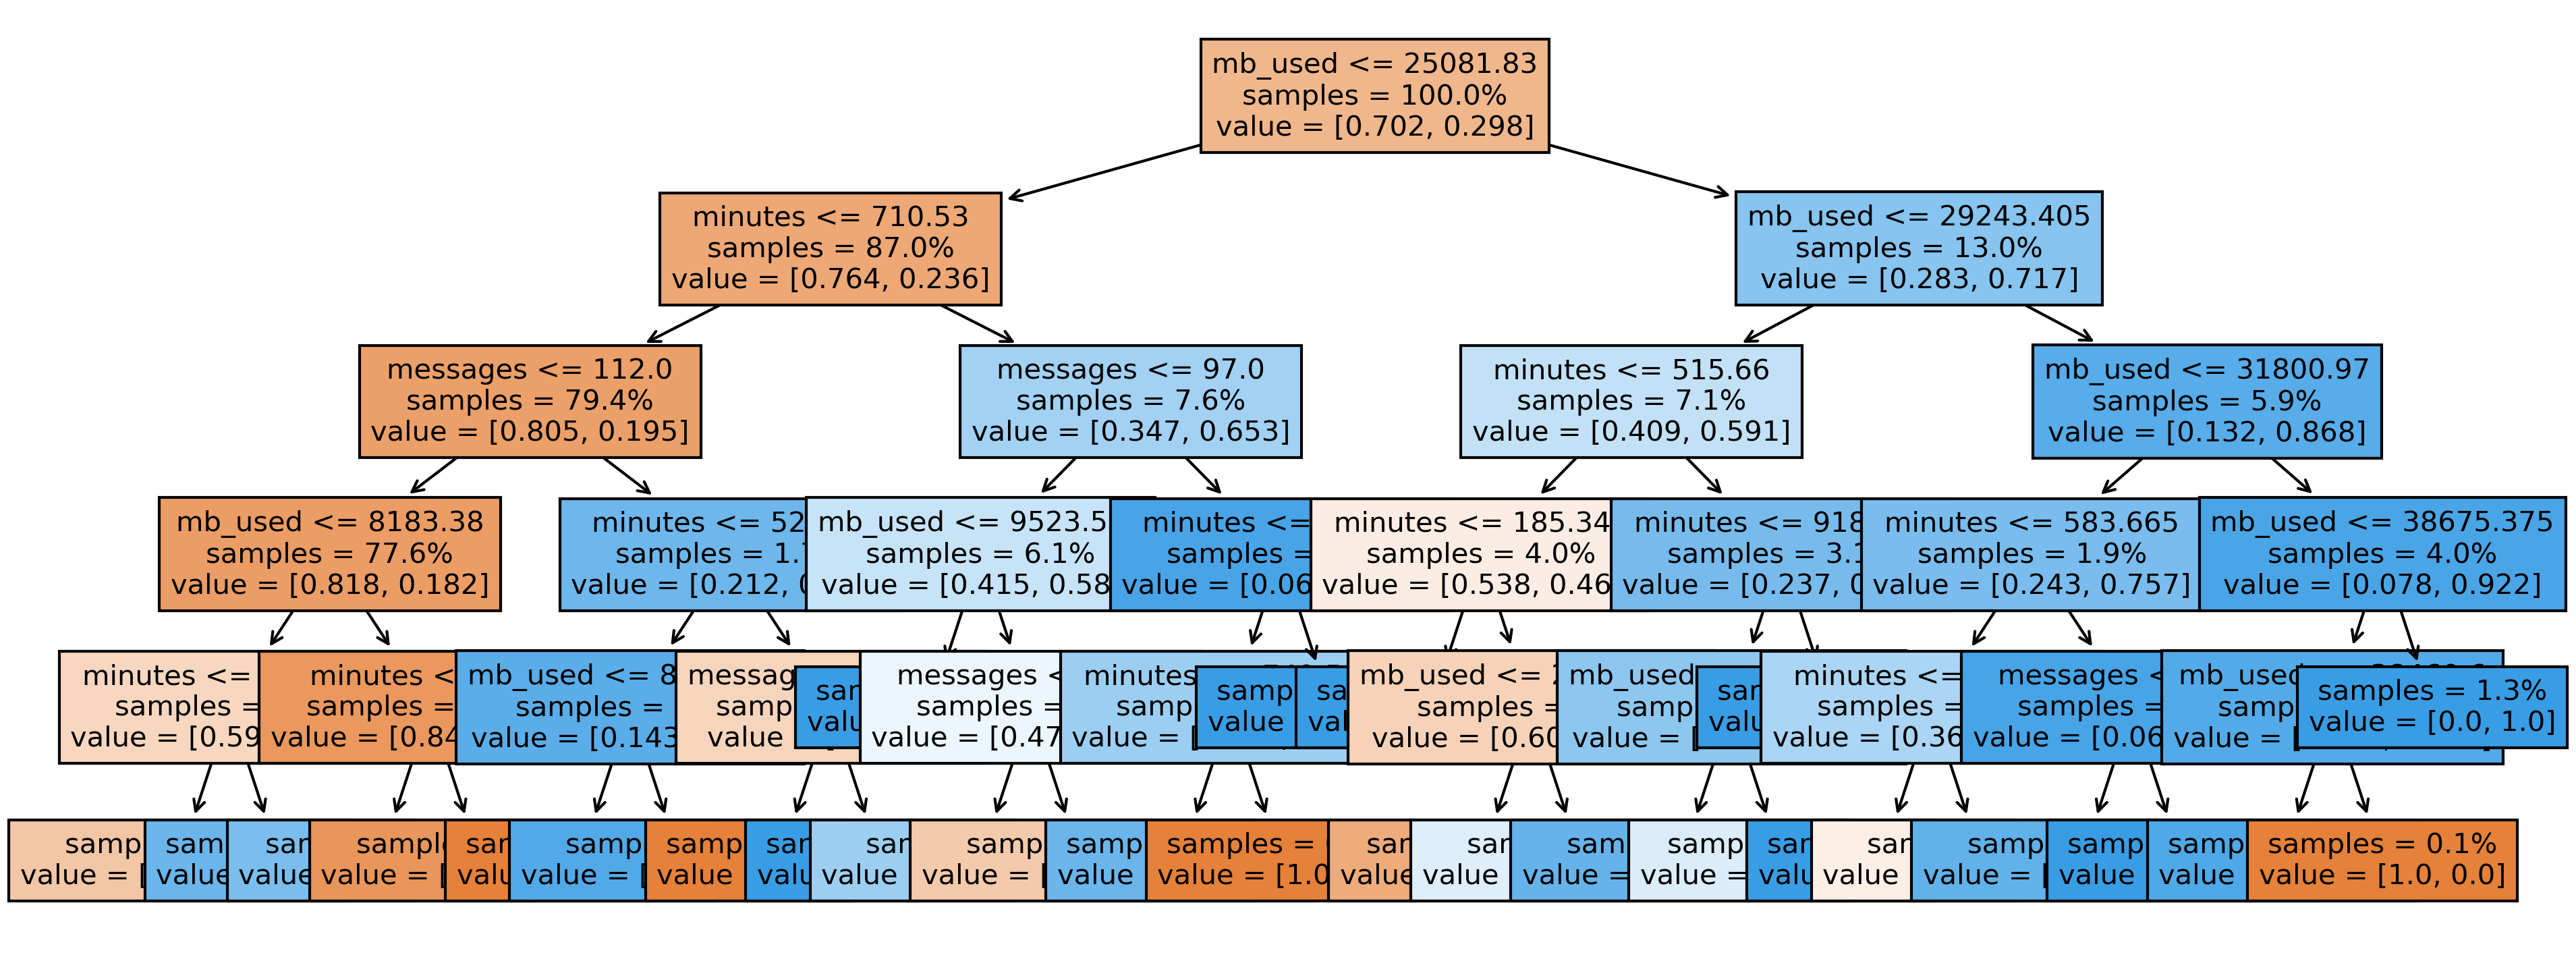

In [43]:
plt.subplots(figsize = (15,6), dpi=300)
tree.plot_tree(best_decision_tree, 
               feature_names=features_train.columns, 
               fontsize=10, 
               filled=True, 
               proportion=True, 
               impurity=False);

При условии глубины дерева 5 довольно не плохо, так как при большей глубине модель начинает переобучаться сортируя группы все меньше и меньше, переставая улавливать основные закономерности

In [44]:
# RandomForest
clf1 = RandomForestClassifier()
param_dist = {
        'n_estimators':range(1,51,5),
        'max_depth':range(2,7,1),
        'random_state':range(47,48,1)
        }

grid = GridSearchCV(clf1, param_dist, scoring = 'accuracy', n_jobs = -1)
grid.fit(features_train, target_train)
best_random_forest = grid.best_estimator_

print(best_random_forest)
print("Accuracy наилучшей модели на валидационной выборке:", round(grid.best_score_, 3))

RandomForestClassifier(max_depth=6, n_estimators=6, random_state=47)
Accuracy наилучшей модели на валидационной выборке: 0.796


In [45]:
# LogisticRegression

model_log_reg = LogisticRegression(random_state=47, max_iter=1000)
model_log_reg.fit(features_train, target_train)
dump(model_log_reg, 'model_9_1.joblib')
log_reg_result = model_log_reg.score(features_valid, target_valid)


print("Accuracy наилучшей модели на валидационной выборке:", round(log_reg_result, 3))

Accuracy наилучшей модели на валидационной выборке: 0.731


**Вывод:**
Наилучший результат показала модель RandomForest

## Проверим модель на тестовой выборке

Проверим обученные модели на тестовой выборке

In [46]:
round(best_random_forest.score(features_test, target_test), 3)

0.795

**Вывод:**
Лучший результат как и на валидационной выборке показывает Случайный лес. Результат выше чем на валидационной выборке, что странно и возможно произошло из-за распределения данных при разделении по выборкам

In [47]:
features_train_valid = data_train_valid.drop(['is_ultra'], axis=1)
target_train_valid = data_train_valid['is_ultra']

In [48]:
# RandomForest
clf1 = RandomForestClassifier()
param_dist = {
        'n_estimators':range(1,51,5),
        'max_depth':range(2,7,1),
        'random_state':range(47,48,1)
        }

grid = GridSearchCV(clf1, param_dist, scoring = 'accuracy', n_jobs = -1)
grid.fit(features_train_valid, target_train_valid)
best_random_forest = grid.best_estimator_

print(best_random_forest)
print("Accuracy наилучшей модели на валидационной выборке:", round(grid.best_score_, 3))

RandomForestClassifier(max_depth=6, n_estimators=31, random_state=47)
Accuracy наилучшей модели на валидационной выборке: 0.802


## Проверим модель на адекватность

Проверку модели на адекватность выполним с помощью метода DummyClassifier. C параметром `most_frequent` он просто выберет самый часто встречающийся параметр в класифицируемом столбце, т.е. "0" в target (те пользователи которые еще не подключены к тарифу Ультра)

In [49]:
dum_model = DummyClassifier(strategy="most_frequent", random_state=47)
dum_model.fit(features_train, target_train)
dum_result = dum_model.score(features_valid, target_valid)

print("Accuracy наилучшей модели на валидационной выборке:", round(dum_result, 3))

Accuracy наилучшей модели на валидационной выборке: 0.678


In [50]:
dum_model.score(features_test, target_test)

0.6842923794712286

In [51]:
round(best_random_forest.score(features_test, target_test) - dum_model.score(features_test, target_test), 3)

0.115

**Вывод:**
Выбранная нами модель на 0.115 лучше предсказывает

## Общий вывод:

В данном проекте мы ознакомились с данными о пользователях оператора сотовой связи для создания модели для задачи классификации, которая выбирала бы подходящий тариф на основании данных о пользователях котороые уже им пользуются.

Мы выполнили дополнительную обработку данных проверив на корреляцию отсеяли лишний столбец с количеством звонков

Разбили датасет на три части для обучения валидации и окончательной проверки

Построили три модели с несколькими возможными вариантами гиперпараметров

Условие для проекта accuracy > 0.75 выполнено

In [52]:
print('Модель показавшая лучший результат подбора тарифа для пользователей')
print(best_random_forest)

Модель показавшая лучший результат подбора тарифа для пользователей
RandomForestClassifier(max_depth=6, n_estimators=31, random_state=47)
